In [1]:
from preprocessing.data_cleaning import get_cleaned_data, split_csv, get_features_label
from preprocessing.encoding import encode_data
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from utils.utils import log_features
from modeling.mrmr import perform_mrmr

In [2]:
df = encode_data(get_cleaned_data())
df = df[df["P1_PT_TYPE"] != 3]
log_features(df)
blood, clinical = split_csv(df)

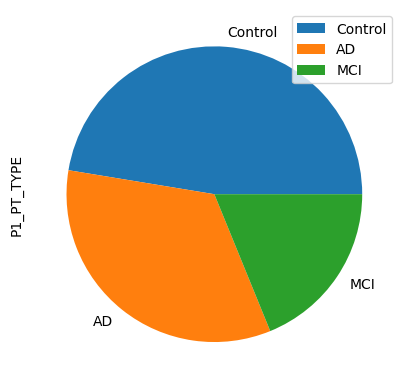

In [3]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

In [ ]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

In [ ]:
plot_correlations(df)

In [ ]:
import pandas as pd
import numpy as np

y, X = get_features_label(df)
y = pd.Series(y)
(features, score, redundancy_matrix) = perform_mrmr(X, y, X.shape[1], scr = True)
score = score.sort_values(ascending=False)
score = score.reset_index()

pairs = {}
for num_features in range(1,X.shape[1]):
    print(num_features)
    test_df = df[score['index'][:num_features]]
    test_df["P1_PT_TYPE"] = df["P1_PT_TYPE"]
    micro_f1_score = test_mrmr_model(test_df)
    pairs[num_features] = micro_f1_score

In [ ]:
import pandas as pd

y, X = get_features_label(df)
y = pd.Series(y)

features, score = perform_mrmr(X, y, 10, True)

In [ ]:
import pandas as pd
label_encoded_df = pd.get_dummies(blood, columns=["P1_PT_TYPE"])

correlations = blood.corr().abs().unstack()
ad_correlations = correlations["P1_PT_TYPE"].sort_values()
print(ad_correlations.index[:100])